In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

# Impediments to learning

The updating of weights, used by Gradient Descent to minimize the loss, can be inhibited in less-than-obvious manners.

In this module, we explore these impediments.

This will motivate the creation of a new class of Layer-types: Normalization.

Simply stated: the power of Neural Networks derives largely from
- the non-linear activation functions 
- the simple weight updating of Gradient descent

But these same non-linear activation functions that provide power sometimes interact badly
with Gradient updates.

Let us examine the plots of the derivatives of the common Activation functions.

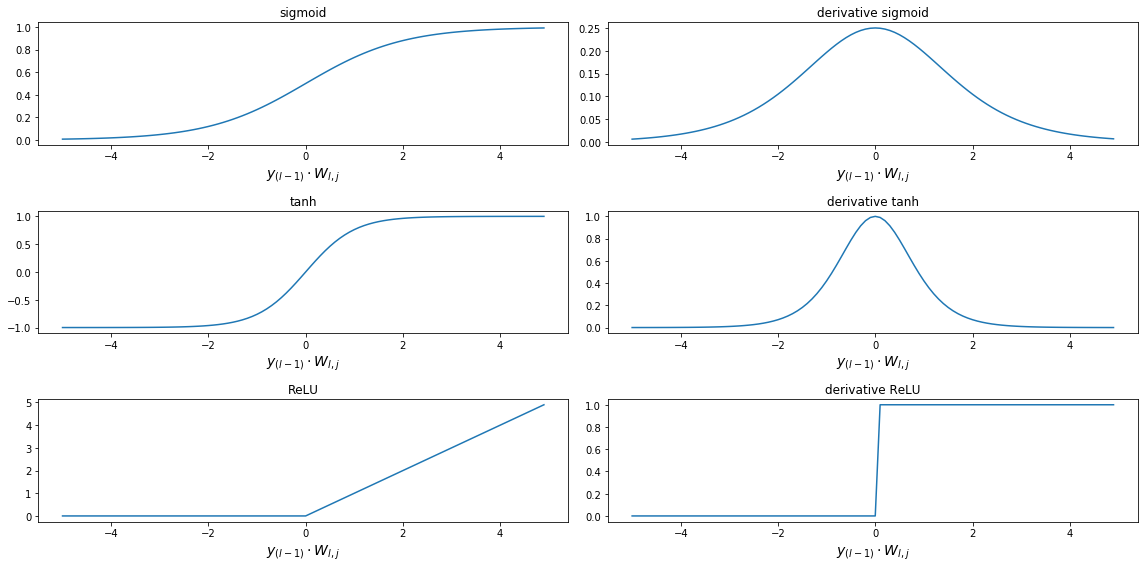

In [4]:
fig, _ = nnh.plot_activations( np.arange(-5,5, 0.1) )

The derivatives of each of these functions has a portion of their domain yielding near zero derivatives.

When the unit that feeds its activation to this Activation function has a value in this domain
- the derivative is zero
- the weight associated with the unit producing this activation will receive a **zero** update from Gradient Descent
    - the unit won't learn


Similarly, there are also portions of the domain with near-linear response.

The composition of linear operations is linear, so a deep network without some active non-linearity
loses all its power.

The "trick" to successful learning is to ensure that
- the distribution of pre-activations 
- are neither **concentrated** in parts of the domain
    - with zero derivative
    - near-linear response
    
Learning works best when the pre-activation distribution is spread-out rather than "peaky".

This module will highlight how a Neural Network may
- wind up in one of the undesirable situations
- the mechanisms that have been devised to avoid them

# Proper scaling of inputs

We briefly explore the statistical properties of the outputs of a layer.
- We show how some of these properties can inhibit learning (weight update)
- Will motivate the Normalization Layer-type, which will maintain good properties of layer outputs



## Importance of zero centered inputs (for each layer)
[Efficient Backprop paper, LeCunn98](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

**Zero centered** means average (over the training set) value of each feature of examples is mean $0$.

Gradient descent updates each element of a layer $\ll$'s weights $\W_\llp$ by
the per-example losses 

$$
\begin{array}[lll] \\
\frac{\partial \loss^\ip }{\partial W_\llp} & = & \frac{\partial \loss^\ip}{\partial \y_\llp^\ip} \frac{\partial \y_\llp^\ip}{\partial \W_\llp} 
\end{array}
$$
summed over examples $i$.

Let's look into the per example loss in more detail.


Since $\W_\llp$ is a vector, the derivative wrt $\W_\llp$ is a vector of derivatives:
$$
\frac{ \partial{\y_\llp^\ip} } { \partial \W_\llp } =
\begin{pmatrix} 
\ldots , \frac{ \partial{\y_\llp^\ip} } { \partial \W_{\llp,} }, \ldots, 
\end{pmatrix}
$$

Examining the $j^{th}$ element of the derivative vector:
$$
\begin{array} \\
\frac{ \partial{\y_\llp^\ip} } { \partial \W_{\llp,j} } & = & \frac{ \partial{ a_\llp ( \y_{(\ll-1)}\cdot \W_\llp ) } } { \partial \W_{\llp,j}} &  \text{ when layer } \ll \text{ is Dense since }  y_\llp = a_\llp ( \y_{(\ll-1)} \cdot \W_\llp ) \; \\
& = &  \frac{ \partial{ a_\llp ( \y_{(\ll-1)}\cdot \W_\llp )} } { \partial (\y_{(\ll-1)}\cdot \W_{\llp})}
       \frac{ \partial{(\y_{(\ll-1)}\cdot \W_\llp)} }{ \W_{\llp,j} } & \text{Chain rule} \\
& =& a'_\llp \y_{(\ll-1),j}^\ip & \text{ since }  \y_{(\ll-1)}\cdot \W_\llp = \sum_j { ( \y_{(\ll-1),j} * \W_{\llp,j} ) }\\
 & & & \text{where } a' = \frac{ \partial{ a_\llp ( \y_{(\ll-1)}\cdot \W_{\llp}) } } { \partial (\y_{(\ll-1)}\cdot \W_{\llp})}\\
\end{array}
$$

This is for $\loss^\ip$, the per-example loss for example $i$.

The (total) Loss $\loss$ is averaged across all $m'$ examples in the mini-batch

So the derivative of the Loss (with respect to the $j^{th}$ weight) $\frac{\partial \loss }{\partial W_{\llp, j}}$ will have the term
$$
\sum_{i=0}^{m'} {  \y_{(\ll-1),j}^\ip  }
$$

Thus, the update to $\W_{\llp, j}$ will be proportional to the average (across the $m'$ examples) of the $j^{th}$ input to layer $\ll$.



To be concrete, let's focus on layer $1$, where 
$$\y_{(\ll -1),j} = \x_j$$
so that
$$
\sum_{i=0}^m {  \y_{(\ll-1),j}^\ip  } = \bar\x_j
$$
i.e., the average (across examples) value of input feature $j$.

In the particular case that the average $\bar{\x}_j$ of *every* feature $j$ has the same sign:
- updates in all weight dimensions will have the same sign (the sign of $a'$)
- Example: two dimensions.  The weight space is $\W_{\llp,0} \times \W_{\llp,1}$
    - We can navigate the the loss surface by moving in the weight space **north-east** or **south-west** only ! 
        - to move south-east: we need to move in a "zig-zag" direction
    - very inefficient way to explore the weight space
<br>
<br>
<table>
    <tr>
        <th><center><strong>RNN many to one API</strong></center></th>
    </tr>
    <tr>
        <td><img src="images/zig_zag_path.png" width=80%></td>
    </tr>
</table>


Although we have illustrated this issue using layer $1$, the issue applies to each layer.

In fact, the issue may be more likely in deeper layers
- when the activation of layer $(\ll-1)$ is *not* zero-centered, e.g., the ReLU and sigmoid

This will motivate the creation of a new layer type whose purpose will be to keep the inputs to successive layers zero-centered.

**Note**

Although we zero center the $m$ examples in the training set, the $m' \lt m$ examples in any mini-batch will not necessarily be zero mean in all features.

## Importance of identical variance across features (weight initialization)

The same argument we made for zero-centering a feature can be extended to it's variance:
- the variance of feature $j$ over all training examples $i$ is the variance of $\y_{(\ll-1),j}$

If the variance of features $j$ and $j'$ are different, their updates will happen at different rates.

We will examine this in greater depth during our discussion of weight initialization.

For now: it is desirable that the input to *each* layer have it's features somewhat normalized.


# Initialization

Training is all about discovering good weights.

As prosaic as it sounds: how do we *initialize* the weights before training ?
Does it matter ?

It turns out that the choice of initial weights does matter.

We will explain why in this module.
- There is an excellent [visualization tool](https://www.deeplearning.ai/ai-notes/initialization/index.html#playground) to illustrate these concepts
    - Play around with different initialization
    - Visualize the weights, gradients
    
Let's start with some *bad* choices

## Bad choices

### Too big/small

Layers usually consist of linear operations (e.g., matrix multiplication and addition of bias)
followed by a non-linear activation.

The range of many activation functions includes large regions where the derivatives are near zero,
usually corresponding to very large/small activations.

Gradient Descent updates weights using the gradients.

Obviously, if the gradients are all near-0, learning cannot occur.

So one bad choice is any set of weights that tends to push activations to regions of the non-linear
activation with zero gradient.

### Dead Activation functions

This is a special case of a too big/small initialization of the **bias** of a unit.

Recall that a layer's pre-activation value is computed as
- dot product of (some or all) layer inputs and weights
- plus the bias (if not already incorporated in the weight vector)

If the layer learns a very large negative bias
- the pre-activation value will likely be a large negative value
- placing the pre-activation value in a region of the Activation Function with zero gradients
- resulting in no update to the bias

Hence, the negative bias with no updates will persist across training steps.
- the unit will not contribute to distinguishing between input examples

We call a unit with constant (commonly $0$, e.g., ReLU) output
- *saturated*
- *dead* activation

### Identical weights

Consider layer $\ll$ with $n_\ll$ units (neurons) implementing identical operations (e.g. FC + ReLu).

Let  $\W_{\llp, k}$ denote the weights of unit $k$.

Suppose we initialized the weights (and biases) of all units to the *same* vector.
$$
\W_{\llp, k} = \w_\llp, \; 1 \le k \le n_\ll
$$

Consider two neuron $j, j'$ in the same layer $\ll$
$$
\begin{array}[lll]\\
\y_{\llp, j}  & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\y_{\llp, j'} & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\end{array}
$$

- Both neuron will compute the same activation
- Both neurons will have the same gradient
- Both neurons will have the same weight update
 

Thus, the weights in layer $i$ will start off identical and will remain identical due to identical updates!

Neurons/units $j$ and $j'$ will never be able to differentiate and come to recognize *different* features.

This negates the advantage of multiple units in a layer.

Many approaches use some for of random initialization to break the symmetry we just described.

This explains the chart we previously saw (training when all weights initialized to zero)
- All weights identical, so no way to break symmetry
- Zero weights lead to zero activation

<img src="images/tnn_loss_and_acc_zero_init.png">

# Maintaining constant variance throughout the layers

Suppose the variance of the features of the input vector for layer $\ll$ (i.e., $\y_{(\ll-1)}$)
- is identical and equal to $\text{Var}$ ($\y_{(\ll-1)}$)

Once it passes through layer $\ll$, what is the output variance $\text{Var}$ ($y_\llp)$ ?
- which is the variance of the input of layer $\ll+1$.

We can illustrate with an experiment
- a network consisting of a sequence of identically sized Fully Connected layers
- plotting the distribution of layer outputs by layer
- through a single epoch: no weight updates

First, we initialize the layer weights with a relatively large variance ($\sigma = 1$)

<table>
    <tr>
        <th><center>Distribution of layer outputs, by layer (shallow to deep)</center></th>
    </tr>
    <tr>
        <th><center>Random Normal weight initialization</center></th>
    </tr>
    <tr>
        <td><img src="images/tnn_activations_shift_large_var.png"></td>
    </tr>
</table>



The large variance forces the pre-activations toward extreme value.  Hence
- the bimodal peaks for the tanh activation
- the large peak of zero values for the ReLU activation

Note that the variance is increasing as we get deeper (top to bottom direction of graphs) into the network

For a very small variance when initializing weights ($\sigma = 0.01$)

<table>
    <tr>
        <th><center>Distribution of layer outputs, by layer (shallow to deep)</center></th>
    </tr>
    <tr>
        <th><center>Random Normal weight initialization</center></th>
    </tr>
    <tr>
        <td><img src="images/tnn_activations_shift_small_var.png"></td>
    </tr>
</table>


The small weight variance causes the pre-activations to tightly cluster
- potentially putting us in the linear regions
    - 0.5 for sigmoid activation
    - 0 for tanh activation

## The cause

Let's examine the mathematical properties of the *pre-activation distribution* of a
Fully Connected layer $\ll$.

That is, the distribution of the dot product 
$$
\y_{(\ll-1)} \cdot W_\llp
$$
for layer $\ll$ computing

$$f_\llp(\y_{(\ll-1)}, W_\llp) = \y_{(\ll-1)} \cdot W_\llp$$

Recall that layer $(\ll-1)$ has $n_{(\ll-1)}$ outputs.



Consider one product term in the dot product $\y_{(\ll-1),j} * \W_{\llp,j}$

We will denote the variance 
- of $\y_{(\ll-1),j}$ as $\text{Var}(Y)$
- of $\W_{\llp,j}$ as $\text{Var}(W)$

and assume both variances are constant across features $j$.

Note: we are making **no** assumption as to the form (e.g., Normal or Uniform) of the distributions.

The *variance* of a product of random variables $Y, W$ 
[is](https://en.wikipedia.org/wiki/Variance#Product_of_independent_variables)

$$
\text{Var}(Y * W) = \mathbb{E}(Y)^2 \text{Var}(W) + \mathbb{E}(W)^2 \text{Var}(Y) + \text{Var}(Y)\text{Var}(W)
$$

For simplicity: let's assume $\mathbb{E}(Y)$ and $\mathbb{E}(W)$ are both zero.

Then 
$$
\text{Var}(Y * W) = \text{Var}(Y)\text{Var}(W)
$$

The problem is that the dot product has *many* product terms
- $n_{(\ll-1)}$ for the input to a Fully Connected layer $\ll$

Hence, the variance of each output feature of Fully Connected layer $\ll$ is
$$
n_{(\ll-1)} * \text{Var}(W) * \text{Var}(Y)
$$

That is:
- the variance of each feature of the output pre-activation
- is $n_{(\ll-1)} * \text{Var}(W)$ greater than the layer's input variance $\text{Var}(Y)$

Thus, the variance of the pre-activation distribution increases as we proceed deeper into the network.

As the variance of the pre-activation gets larger
- we are more likely to be in one of the extremes of the domain of the Activation function
- where derivatives are often near-zero

Hence, we wind up in an unfavorable region of the Activation function.

## Glorot initialization

Fortunately, there is a simple solution to the exploding pre-activation variance
- initialize the weights $W_\llp$ of Fully Connected layer $\ll$
- to have variance $\frac{1}{n_{(\ll-1)}}$
- by initializing to a unit variance distribution and scaling by 

$$
\frac{1}{\sqrt{n_{(\ll-1)}}}
$$


This forces the dot product to have unit variance

This is the basis for *Glorot/Xavier Initialization*

This only partially solves the problem as it only ensures unit variance of the **input** to the activation function.

If we can make the **output** of the activation also have unit variance then
- the input to each layer is unit variance
- and the output (which is input to the next layer) is also unit variance

Hence the output variance of each activation function remains constant as we proceed through the network.

The [original Glorot paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) justifies this
- By assuming either a $\tanh$ or sigmoid activation function
- Which are approximately linear in the active region.
- So the **output** of the activation function is equal to the input in this region
- And is therefore unit variance as desired

Thus far, we have achieved unit variance during the forward pass.

During back propagation
- It can be  shown that the scaling factor
- Depends on the number of outputs $n_\llp$ of layer $\ll$, rather than the number of inputs $n_{(\ll-1)}$
    - because we move from deep to shallow in the backward pass
    - rather than shallow to deep as n the forward pass
- Thus, the scaling factor needs to be $\frac{1}{\sqrt{n_\llp}}$ rather than $\frac{1}{\sqrt{n_{(\ll-1)}}}$

Taking the average of the two scaling factors gives a final factor of
$\frac{1}{\sqrt{ \frac{ n_{(\ll-1)} + n_\llp}{2} } } = \sqrt{\frac{2}{n_{(\ll-1)} + n_\llp}}
$

which is what you often see in papers using this form of initialization.

## Kaiming/He initialization

Glorot/Xavier initialization was tailored to two particular activation functions ($\tanh$ or sigmoid).

[Kaiming et al](https://arxiv.org/pdf/1502.01852.pdf) extended the results
to the ReLU activation.

The ReLU activation has two distinct regions: one linear (for inputs greater than 0) and one all zero.

The linear region of the activation corresponds to the assumption of the Glorot method.

So if inputs to the ReLU are equally distributed around 0, this is approximately the same
as the Glorot method with half the number of inputs.
- that is: half of the ReLU's will be in the active region and half will be in the inactive region.

The Kaiming scaling factor is thus:
$$
\sqrt{\frac{2}{n_{(\ll-1)}} }
$$
in order to preserve unit variance.

## Limits of good initialization

The Glorot and Kaiming/He initializers implicitly assume
- a sequential network: connections only between consecutive layers

It has been observed that, when Residual connections are allowed, the analysis is flawed.

Other techniques (such as Batch Normalization, to be introduced shortly) must be used.

## Layer-wise pre-training

In the early days of Deep Learning
- Before good weight initialization techniques were discovered
- A technique called *Layer-wise pre-training* was very popular

We can motivate this technique by briefly introducing an Autoencoder network.


<table>
    <tr>
        <th><center>Autoencoder</center></th>
    </tr>
    <tr>
        <td>
            <img src="images/Autoencoder_vanilla.png">
        </td>
    </tr>
</table>

An Autoencoder network has two parts
- An Encoder, which takes input $\x$ and "encodes" it into $\z$
- A Decoder, which takes the encoding $\z$ and tries to reproduce $\x$

Each part has its own weights, which can be discovered through training, with examples
- $\langle \X, \y \rangle = \langle \X, \X \rangle$

That is: we are asking the output to be identical to the input.

This will not be possible
when the dimension of $\z$ is less than the dimension of $\x$.
- $\z$ is a *bottle-neck*

$\z$ becomes a *reduced-dimensionality* approximation of $\x$.

This is quite similar to discovering Principal Components.
- We discover a small number of synthetic features $\z$ that summarize the diversity of $\y_{(\ll-1)}$

What does this have to do with layer-wise initialization of weights ?
- We construct an Autoencoder with layer $\ll$ serving the role of the Encoder
- We 
    - train the Autoencoder on layer $\ll$ inputs
    - and subsequently discard the Decoder

The weights for layer $\ll$ obtained from Autoencoder training
- are non-random
- meaningful in the sense that they solve the Autoencoding task
- hopefully transfer to our original task better than random weights



The weights we create
- Are not random, they meet the Autoencoder task objective
- Perhaps non-random weights are better initializers because they discover some structure of the input

Transfer Learning (the subject of another module) works in a similar manner
- Use the weights obtained from training on a Source task
- To use as initial weights for a second Target task

# Batch Normalization

We addressed the importance of normalization of the inputs to layer $\ll = 1$.

But confining our attention to layer $1$ is not sufficient
- The same argument for normalization of layer inputs applies to *all* layers $\ll > 0$.
- Initialization occurs only before the first mini-batch of the first epoch
    - need to maintain a good distribution across all mini-batches and all epochs


This motivates the introduction of a new class of layer-types: Normalization layers

- These layer types attempt to keep the distribution of $\y_{\llp,j}$
normalized through all layers $\ll$ and training steps
- They become most necessary for *very deep* (large number of layers) networks

Normalization layers were one of the innovations that advanced Deep Learning
by enabling learning in networks of extreme depth.



**Reference**

[Batch Normalization paper](https://arxiv.org/abs/1502.03167)

If our goal is to ensure that the output distribution of each layer is identical
- there is a simple solution
- apply a standardization layer to each activation output to ensure mean $0$, variance outputs

Batch Normalization is a layer type that essentially carries out this standardization

It is called  *batch* normalization because
- the mean and variance used for standardization is computed on a *per batch* basis
- hopefully, each batch's statistics are an approximation of the statistics of the true training distribution

Experimental results show that the technique:
- facilitates the use of much higher learning rates, thus speeding training.  Accuracy is not lost.
- facilitates the use of saturating activations functions (e.g., $\tanh$ and sigmoid) which otherwise are subject to vanishing/exploding gradients.
- acts as a regularizer; reduces the need for Dropout
    - L2 regularization (weight decay) has *no* regularizing effect when used with Batch Normalization !
        - [see](https://arxiv.org/abs/1706.05350)
        - L2 regularization affects scale of weights, and thereby learning rate

## Details

Consider a layer $\ll$ computing
$$
\y_\llp = a_\llp( f_\llp(\y_{(\ll-1)}, W_\llp) )
$$

We use 
- superscript $i$ to denote the value of $\y_\llp$ when the Neural Network input
is example $i$.
- $m_B$ to denote the number of examples in a mini-batch.

Batch Normalization of layer $\ll$ output is defined by the following equations
- producing standardized output $\z^\ip$ given 
Neural Network input
is example $i$.

$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\y_\llp^\ip} & \quad  \text{Batch mean}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\y_\llp^\ip - \mathbf{\mu}_B)^2} & \quad \text{Batch variance} \\
3.\quad & \hat\y_\llp^\ip = \dfrac{\y_\llp^\ip - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}} & \quad \text{Standardize } \y_\llp^\ip\\
4.\quad & \mathbf{z}^\ip = \gamma \hat\y_\llp^\ip + \beta  & \quad \text{De-Standardize } \hat\x^\ip  \text{ with learned mean and variance}\\
\end{split}
$

**Notes**
- The $\epsilon$ in the denominator is there solely to prevent "divide by 0" errors
- The statistics are computed for each feature
    - so $\mu_B$ and $\sigma_B$ are vectors of length $n_\llp$
- Normalization is sometimes defined with respect to 
    - the pre-activation outputs $f_\llp(\y_{(\ll-1)}, W_\llp)$
    - rather than the activation outputs $\y_\llp$
    


The first 3 steps is simple standardization by the mean and variance of the mini-batch.

But: after we obtain standardized $\hat\y_\llp^\ip$ we 
- shift the mean from $0$ to $\beta$
- scale the standard deviation by $\gamma$
- to obtain the final output $\z^\ip$

where $\beta$ and $\gamma$ are **learned parameters**.

What is the point of changing from the distribution to mean $\beta$, variance $\gamma^2$ ?

It can't hurt:
- if the optimal values are $\beta = 0$ and $\gamma = 1$ so that $\z^\ip = \hat\y_\llp^\ip$
    - these are the values that will be learned
- if there is an advantage to the shift: it will be learned    
    - if we are normalizing the pre-activation inputs (rather than the activation outputs)
    - the standardized $\hat\y_\llp^\ip$ may wind up in a linear region of the activation function
    - resulting in a linear transformation
    - shifting may move the result to a non-linear part of the activation function
        - resulting in a non-linear transformation: more powerful


At inference time
- all the parameters ($\mu_B, \sigma_B, \beta, \gamma$) are fixed
- the $\mu_B$ and $\sigma_B$ used for each batch are *identical* across mini-batches
    - are "population" statistics $\mu, \sigma$ computed over the full training dataset
    - usually by a decaying moving average


Keras has a `BatchNormalization` layer type to perform Batch Normalization of its inputs.



Using our running example as illustration
- The following chart shows the effect of adding a `BatchNormalization` layer after the first few `Dense` layers


<table>
    <tr>
        <td><center>RELU</center></td> 
        <td><center>SIGMOID</center></td>
        <td><center>TANH</center></td>
    </tr>
    <tr>
        <td colspan="3">
            <img src="images/tnn_loss_and_acc_bn.png">
    </tr>
</table>

We observe that `BatchNormalization`
- when used on the network with Sigmoid activations
- significantly improves the Loss and Accuracy compared to the network without it
- We can see the output of the `BatchNormalization` layer roughly maintains
    - mean $0$ and unit variance across epochs
    
<table>
    <tr>
        <td><center>RELU</center></td> 
        <td><center>SIGMOID</center></td>
        <td><center>TANH</center></td>
    </tr>
    <tr>
        <td colspan="3">
            <img src="images/tnn_activations_bn.png">
    </tr>
</table>

## Conclusion


Batch Normalization is almost a "magic bullet" for training
- avoids problems caused by covariate shift
- and *also* facilitates higher learning rates
    - accelerating training


There are some theories as to why it enables higher learning rates
- the weights are updated by the product of the learning rate and the derivatives
    - by controlling the size of the derivatives
    - we can use a larger learning rate
    - without increasing the size of the update
- the $\mu_B$ and $\sigma_B$ of each mini-batch are *noisy estimates* of the training set's mean and variance
    - since these values vary by mini-batch, noise is added to training
    - act as a form of regularization
        - forcing the Neural Network's weights to not overly-adapt to each batch
        - similar to the regularization effect seen in Dropout.


## Final words

There are several other common forms of Normalization:
- [Layer Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization)
- [Group Normalization](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/GroupNormalization)

In practice, to mitigate the cost to training and inference
- normalization layers are only applied every few layers, not for every layer

There is also some controversy over the wisdom of [using both Batch Normalization and Dropout](https://arxiv.org/pdf/1801.05134.pdf). Essentially:
- Dropout causes the batch statistics computed at training time
- to differ from the population statistics of the training dataset
- which means that the test dataset does not reflect the same distribution as was used in training


## BatchNormalization and Transfer Learning (subtlety)

This is a subtle and technical point involving using
- Pre-trained models
- In Transfer Learning (a subsequent module)

You might want to revisit this section once you start to use Pre-Trained models and Transfer Learning.

Transfer Learning in a nutshell:
- freeze the weights of a Pre-Trained "Base" model that has been trained on a Source Task, using many examples
- train *only* newly added layers in order to adapt the augmented model to a Target task
    - using a *small* number of training examples for the Target Task
- this is an effective way to solve a new Target Task with less effort than training a model from scratch
    - "Transfer" the knowledge encoded in the parameters during training of the Source Task
        - to the Target Task

The issue arises from freezing the base model when it contains normalization layers
- Batch Normalization layers are unique in that they contain *non-trainable* weights
    - in addition to the usual trainable weights
    - the non-trainable weights are the batch statistics
        - computed values, but not part of the trainable weights

The question becomes: what happens to the non-trainable weights during training when the layer is frozen ?

The answer revolves around a technical distinction between *inference mode* and *frozen state*
- "Inference mode" is what happens when the model is not training
    - For `BatchNormalization`: uses the population statistics during *inference*
- "Frozen state" is what happens during training when a layer's weights are frozen; `layer.trainable = False`
    - recall: the batch statistics are *not* trainable weights, so should not be affected by `layer.trainable`
        - might expect batch statistics to always be used
    - For `BatchNormalization`, it was decided instead
        - `layer.trainable = False` means the layer operates in *inference model*
            - even when the model is training (i.e, not performing inference)
        -  results in using the population statistics during *training*
            - rather than batch statistics
    

One reason for this decision
- in Transfer Learning, we usually set `trainable = False` for the *entire model*
    - which recursively sets `trainable = False` for all the model layers
        - including `BatchNormalization`
    - rather than freezing layers individually
    - it is therefore easy to accidentally set `trainable = False` for `BatchNormalization`
    
So the decision was made to treat `trainable = False` for `BatchNormalization` layers
- in a non-standard way
- to capture the user's intent during Transfer Learning

# Conclusion

Maintaining good properties of layer inputs throughout the depth of a multi-layer network
is like priming a pump.

Proper priming helps our learning to flow smoothly.

We explored some of the stumbling blocks to learning (weight update) along with their solutions.

In [5]:
print("Done")

Done
